In [1]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
from snntorch import utils

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


# Loading and Encoding Data
https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_1.html
## load mnist

In [3]:
# Training Parameters
batch_size=128
data_path='./data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

In [4]:
mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)

In [5]:
# use a portion of data by defined factor
subset = 10
mnist_train = utils.data_subset(mnist_train, subset)

In [6]:
mnist_train

Dataset MNIST
    Number of datapoints: 6000
    Root location: ./data/mnist
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=(0,), std=(1,))
           )

In [7]:
# DataLoader
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
train_loader

## rate encoding

In [8]:


# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)
print(data_it.shape)
# Spiking Data
num_steps = 100
spike_data = spikegen.rate(data_it, num_steps=num_steps)
print(spike_data.shape)

torch.Size([128, 1, 28, 28])
torch.Size([100, 128, 1, 28, 28])


The corresponding target is: 5


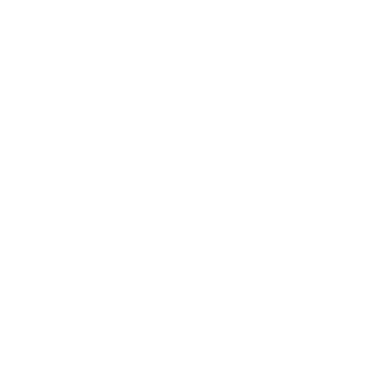

In [16]:
number_indexed = 2
spike_data_sample = spike_data[:, number_indexed, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
# https://www.gyan.dev/ffmpeg/builds/packages/ffmpeg-8.0-essentials_build.7z
plt.rcParams['animation.ffmpeg_path'] = 'C:\\ffmpeg\\bin\\ffmpeg.exe'
print(f"The corresponding target is: {targets_it[number_indexed]}")
HTML(anim.to_html5_video())

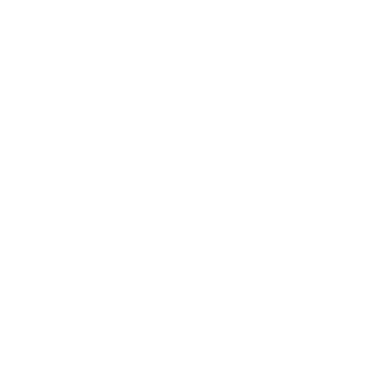

In [19]:
spike_data_lowrate = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data_lowrate[:, number_indexed, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
HTML(anim.to_html5_video())

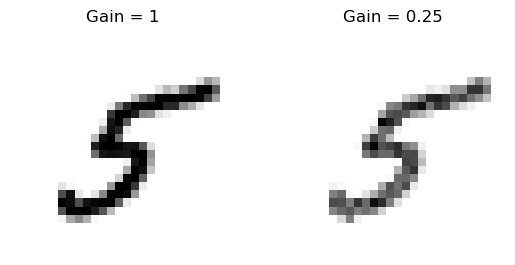

In [20]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

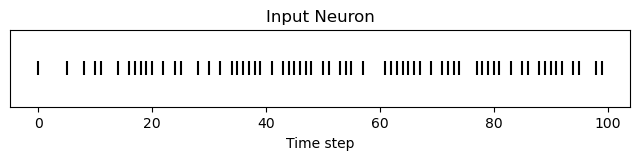

In [24]:
idx = 221  # index into 210th neuron
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

## latency encoding

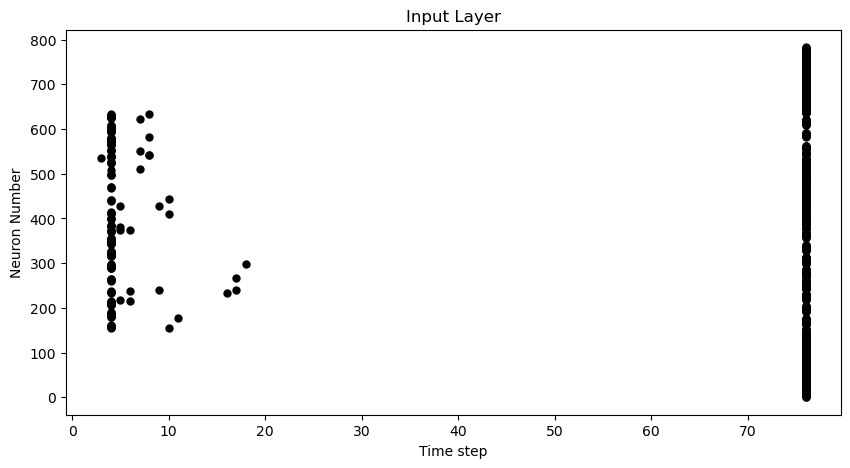

In [33]:
spike_data = spikegen.latency(data_it, num_steps=num_steps, tau=5, threshold=0.5)
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

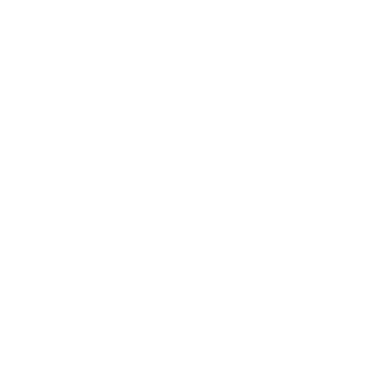

In [36]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data[:, 0, 0], fig, ax)

HTML(anim.to_html5_video())

## delta encodng, for time series data

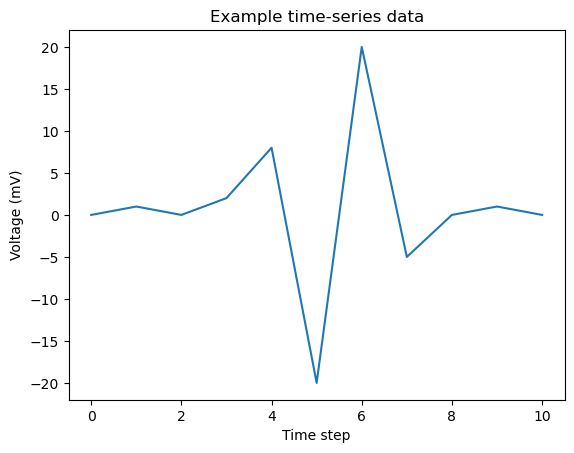

In [38]:
data = torch.Tensor([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0])

# Plot the tensor
plt.plot(data)

plt.title("Example time-series data")
plt.xlabel("Time step")
plt.ylabel("Voltage (mV)")
plt.show()

tensor([ 0.,  0.,  0.,  0.,  1., -1.,  1., -1.,  1.,  0.,  0.])


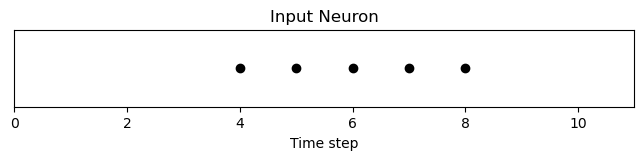

In [40]:
# Convert data
spike_data = spikegen.delta(data, threshold=4, off_spike=True)
print(spike_data)
# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

## Decoding

In [ ]:
# spike count
_, idx = output.sum(dim=0).max(1)

# cross entropy by membrain potential


# LIF Cell

In [120]:
#@title Plotting Settings
def plot_mem(mem, title=False):
  if title:
    plt.title(title)
  plt.plot(mem)
  plt.xlabel("Time step")
  plt.ylabel("Membrane Potential")
  plt.xlim([0, 50])
  plt.ylim([0, 1])
  plt.show()

def plot_step_current_response(cur_in, mem_rec, vline1):
  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur_in, c="tab:orange")
  ax[0].set_ylim([0, 0.2])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title("Lapicque's Neuron Model With Step Input")

  # Plot membrane potential
  ax[1].plot(mem_rec)
  ax[1].set_ylim([0, 0.6]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  if vline1:
    ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.xlabel("Time step")

  plt.show()


def plot_current_pulse_response(cur_in, mem_rec, title, vline1=False, vline2=False, ylim_max1=False):

  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur_in, c="tab:orange")
  if not ylim_max1:
    ax[0].set_ylim([0, 0.2])
  else:
    ax[0].set_ylim([0, ylim_max1])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem_rec)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  if vline1:
    ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  if vline2:
    ax[1].axvline(x=vline2, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.xlabel("Time step")

  plt.show()

def compare_plots(cur1, cur2, cur3, mem1, mem2, mem3, vline1, vline2, vline3, vline4, title):
  # Generate Plots
  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur1)
  ax[0].plot(cur2)
  ax[0].plot(cur3)
  ax[0].set_ylim([0, 0.2])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem1)
  ax[1].plot(mem2)
  ax[1].plot(mem3)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline2, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline3, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline4, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)

  plt.xlabel("Time step")

  plt.show()

def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, 0.4])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

def plot_spk_mem_spk(spk_in, mem, spk_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)
  plt.yticks([]) 

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()


def plot_reset_comparison(spk_in, mem_rec, spk_rec, mem_rec0, spk_rec0):
  # Generate Plots to Compare Reset Mechanisms
  fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4], 'wspace':0.05})

  # Reset by Subtraction: input spikes
  splt.raster(spk_in, ax[0][0], s=400, c="black", marker="|")
  ax[0][0].set_ylabel("Input Spikes")
  ax[0][0].set_title("Reset by Subtraction")
  ax[0][0].set_yticks([])

  # Reset by Subtraction: membrane potential 
  ax[1][0].plot(mem_rec)
  ax[1][0].set_ylim([0, 0.7])
  ax[1][0].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1][0].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)

  # Reset by Subtraction: output spikes
  splt.raster(spk_rec, ax[2][0], s=400, c="black", marker="|")
  ax[2][0].set_yticks([])
  ax[2][0].set_xlabel("Time step")
  ax[2][0].set_ylabel("Output Spikes")

  # Reset to Zero: input spikes
  splt.raster(spk_in, ax[0][1], s=400, c="black", marker="|")
  ax[0][1].set_title("Reset to Zero")
  ax[0][1].set_yticks([])

  # Reset to Zero: membrane potential
  ax[1][1].plot(mem_rec0)
  ax[1][1].set_ylim([0, 0.7])
  ax[1][1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  ax[1][1].set_yticks([])
  ax[2][1].set_xlabel("Time step")

  # Reset to Zero: output spikes
  splt.raster(spk_rec0, ax[2][1], s=400, c="black", marker="|")
  ax[2][1].set_yticks([])

    #@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()



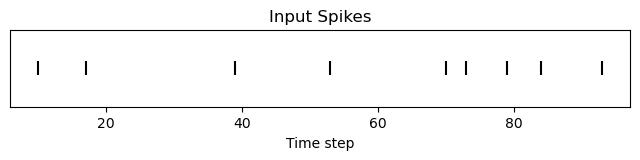

In [106]:
# Create a 1-D random spike train. Each element has a probability of 40% of firing.
spk_in = spikegen.rate_conv(torch.ones((num_steps,1)) * 0.1)
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spk_in.reshape(num_steps, -1), ax, s=100, c="black", marker="|")
plt.title("Input Spikes")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

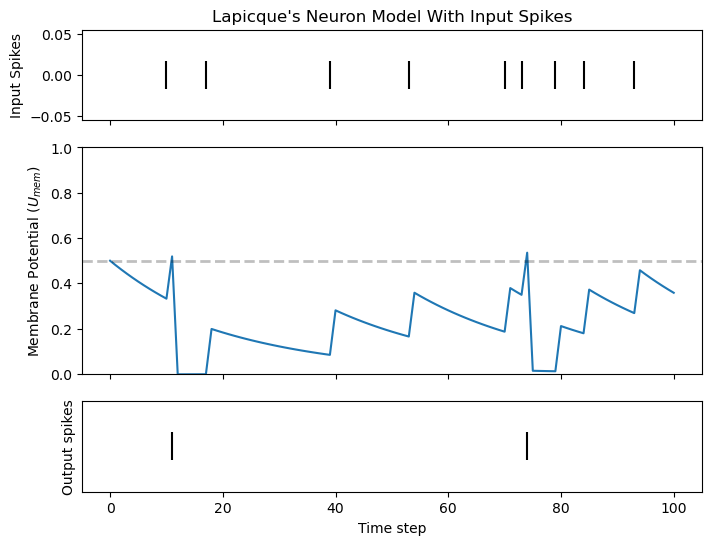

In [108]:
time_step = 1e-3
R = 5
C = 5e-3

# leaky integrate and fire neuron, tau=5e-3
lif = snn.Lapicque(R=R, C=C, time_step=time_step, threshold=0.5, reset_mechanism="subtract")

# Initialize inputs and outputs
mem = torch.ones(1)*0.5
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# Neuron simulation
for step in range(num_steps):
  spk_out, mem = lif(spk_in[step], mem)
  spk_rec.append(spk_out)
  mem_rec.append(mem)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_spk_mem_spk(spk_in, mem_rec, spk_rec, "Lapicque's Neuron Model With Input Spikes")

## Simplified LIF
standard LIF cell
```
def leaky_integrate_and_fire(mem, x, w, beta, threshold=1):
  # beta = exp(- time-step/tau)
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = beta * mem + w*x - spk*threshold
  return spk, mem
```
`lif_simplified = snn.Leaky(beta=0.8)`
more cell types: https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_4.html

## Feedforward Network
build a 784-1000-10 fc nn


In [128]:
# layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
lif1 = snn.Leaky(beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)

# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

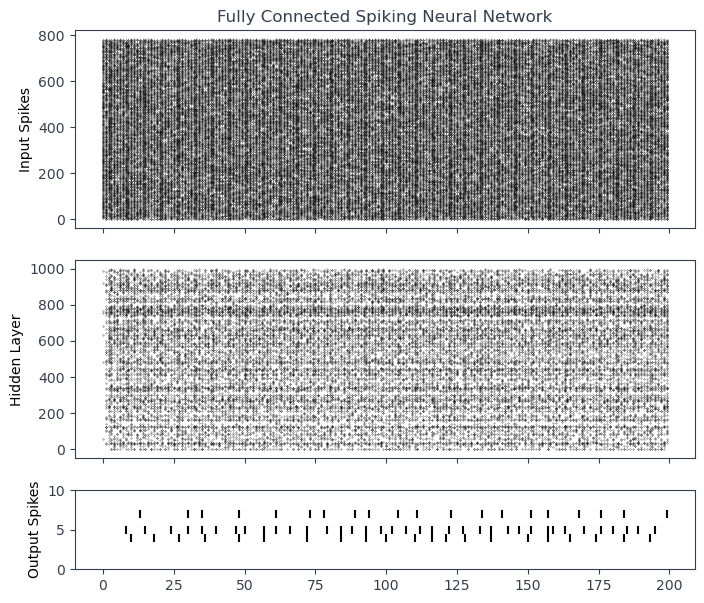

In [129]:
num_steps = 200
# network simulation
spk_in = spikegen.rate_conv(torch.rand((num_steps, 784))).unsqueeze(1)

for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

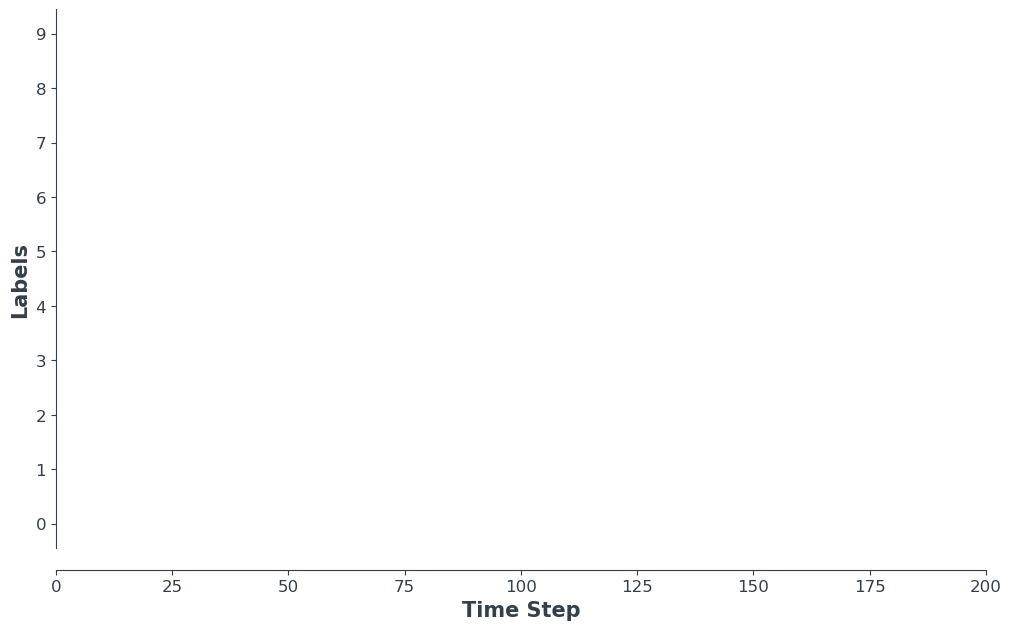

In [130]:
# count spikes
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()

#  Plot spike count histogram
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
HTML(anim.to_html5_video())

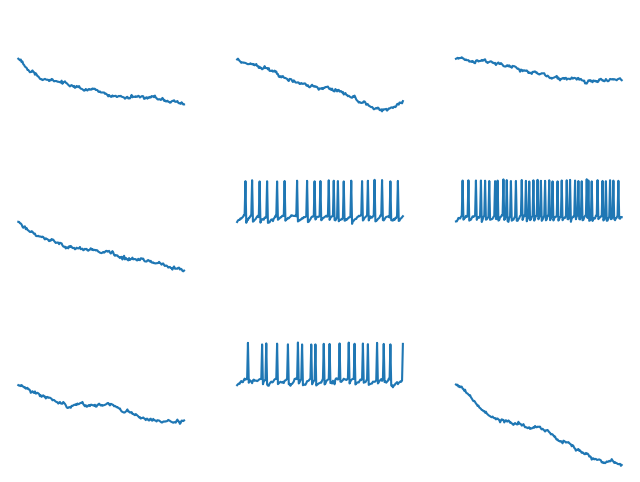

In [131]:
# plot membrane potential traces
splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(1))
fig = plt.gcf() 
fig.set_size_inches(8, 6)

## Differentiable Lif using Surrogate Gradient

In [132]:
class LeakySurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0):
      super(LeakySurrogate, self).__init__()

      # initialize decay rate beta and threshold
      self.beta = beta
      self.threshold = threshold
      self.spike_gradient = self.ATan.apply

  # the forward function is called each time we call Leaky
  def forward(self, input_, mem):
    spk = self.spike_gradient((mem-self.threshold))  # call the Heaviside function
    reset = (self.beta * spk * self.threshold).detach()  # remove reset from computational graph
    mem = self.beta * mem + input_ - reset  # Eq (1)
    return spk, mem

  # Forward pass: Heaviside function
  # Backward pass: Override Dirac Delta with the derivative of the ArcTan function
  @staticmethod
  class ATan(torch.autograd.Function):
      @staticmethod
      def forward(ctx, mem):
          spk = (mem > 0).float() # Heaviside on the forward pass: Eq(2)
          ctx.save_for_backward(mem)  # store the membrane for use in the backward pass
          return spk

      @staticmethod
      def backward(ctx, grad_output):
          (spk,) = ctx.saved_tensors  # retrieve the membrane potential
          grad = 1 / (1 + (np.pi * mem).pow_(2)) * grad_output # Eqn 5
          return grad

In [133]:
lif1 = LeakySurrogate(beta=0.9)

# MNIST Training



## Dataset
- Original densed input data is used, no encoding is applied 

In [2]:
# dataloader arguments
batch_size = 128
data_path='./data'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

## Network Architecture

- Binary LIF activation is used as activation function, rather than ReLU
- LIF's membrane potential is acculuated across time steps with a `for step in range(num_steps)` loop
- Both spikes and potentials are recorded, for target prediction and model backprop

In [138]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

# Define Network: same 784-1000-10 fc nn
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

## Feed-Forward

- Spike count is used for prediction, aka rate decoding

In [ ]:
def batch_accuracy(spk_rec, targets, train=False):
    # spk_rec, _ = net(data.view(batch_size, -1))
    _, idx = spk_rec.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())
    print(f"single minibatch accuracy is {acc*100:.2f}%")

In [181]:
# Feed-Forward
data, targets = next(iter(train_loader))
spk_rec, mem_rec = net(data.view(batch_size, -1))
print(mem_rec.shape)
batch_accuracy(spk_rec, targets)

torch.Size([25, 128, 10])
single minibatch accuracy is 60.94%


## Calculate Loss

- Membrane potential is used for loss using cross entropy against targets
- promote high potential for true label and low potential for false labels
- loss is calculated and accumulated at every time step

In [144]:
# torch built-in loss function
loss = nn.CrossEntropyLoss()

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every time-step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)
loss_val

tensor([62.3458], grad_fn=<AddBackward0>)

## Back-prop

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

In [ ]:
# rerun cells above to observe higher acc and lower loss
data, targets = next(iter(train_loader))
spk_rec, mem_rec = net(data.view(batch_size, -1))
print_batch_accuracy(spk_rec, targets)

loss_val = torch.zeros((1), dtype=dtype, device=device)
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)
print(f"Training loss: {loss_val.item():.3f}")

## Training Loop

- Put everything in one loop

In [182]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [185]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0



# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        
        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 7.61
Test Set Loss: 8.43
Train set accuracy for a single minibatch: 88.28%
Test set accuracy for a single minibatch: 91.41%


Epoch 0, Iteration 50
Train Set Loss: 7.52
Test Set Loss: 3.85
Train set accuracy for a single minibatch: 93.75%
Test set accuracy for a single minibatch: 96.09%


Epoch 0, Iteration 100
Train Set Loss: 8.72
Test Set Loss: 4.46
Train set accuracy for a single minibatch: 87.50%
Test set accuracy for a single minibatch: 97.66%


Epoch 0, Iteration 150
Train Set Loss: 7.51
Test Set Loss: 5.11
Train set accuracy for a single minibatch: 93.75%
Test set accuracy for a single minibatch: 93.75%


Epoch 0, Iteration 200
Train Set Loss: 3.85
Test Set Loss: 6.03
Train set accuracy for a single minibatch: 99.22%
Test set accuracy for a single minibatch: 96.88%


Epoch 0, Iteration 250
Train Set Loss: 6.35
Test Set Loss: 6.88
Train set accuracy for a single minibatch: 92.19%
Test set accuracy for a single minibatch: 92.19%


Epoch 0, Iter

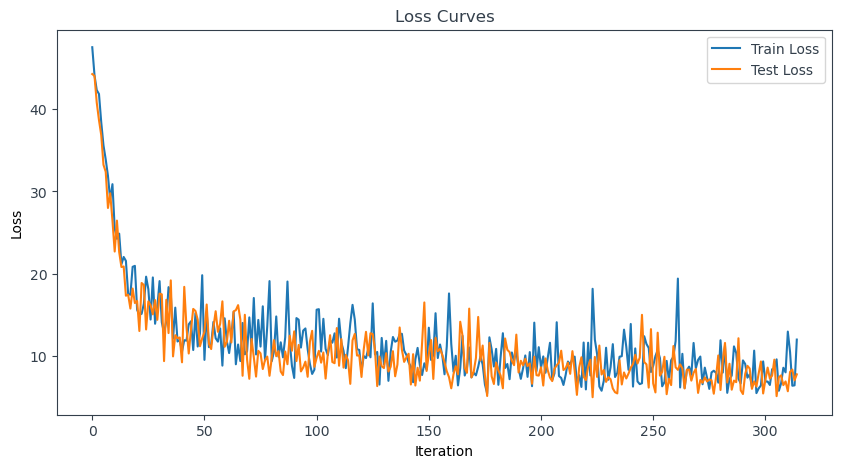

In [184]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
## Benchmark on Test Dataset

In [186]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9401/10000
Test Set Accuracy: 94.01%


# CNN network

In [188]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # Initialize layers
#         self.conv1 = nn.Conv2d(1, 12, 5)
#         self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
#         self.conv2 = nn.Conv2d(12, 64, 5)
#         self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
#         self.fc1 = nn.Linear(64*4*4, 10)
#         self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

#     def forward(self, x):

#         # Initialize hidden states and outputs at t=0
#         mem1 = self.lif1.init_leaky()
#         mem2 = self.lif2.init_leaky()
#         mem3 = self.lif3.init_leaky()

#         cur1 = F.max_pool2d(self.conv1(x), 2)
#         spk1, mem1 = self.lif1(cur1, mem1)

#         cur2 = F.max_pool2d(self.conv2(spk1), 2)
#         spk2, mem2 = self.lif2(cur2, mem2)

#         cur3 = self.fc1(spk2.view(batch_size, -1))
#         spk3, mem3 = self.lif3(cur3, mem3)

#         return spk3, mem3
beta = 0.9
cnn = nn.Sequential(nn.Conv2d(1, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, init_hidden=True),
                    nn.Conv2d(12, 64, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(64*4*4, 10),
                    snn.Leaky(beta=beta, init_hidden=True, output=True)
                    )

In [189]:
# wrap the feed forward in a function
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net
  
  # record spike and membrane
  for step in range(num_steps):
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [190]:
# Loss by spike count
import torch.nn.functional as F
from snntorch import functional as SF
loss_fn = SF.ce_rate_loss()

In [201]:
# load a mini batch, feed-forward, loss, acc
data, targets = next(iter(train_loader))
spk_rec, mem_rec = forward_pass(cnn, num_steps, data)
loss_val = loss_fn(spk_rec, targets)
print(targets.shape)
print(f"The loss from an untrained network is {loss_val.item():.3f}")
acc = SF.accuracy_rate(spk_rec, targets)
print(f"The accuracy of a single batch using an untrained network is {acc*100:.3f}%")

torch.Size([128])
The loss from an untrained network is 2.314
The accuracy of a single batch using an untrained network is 8.594%


In [207]:

# training loop
cnn_optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 1
loss_hist = []
test_acc_hist = []
counter = 0

# overall accuracy
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()
    train_loader = iter(train_loader)
    for data, targets in train_loader:
      spk_rec, _ = forward_pass(net, num_steps, data)
      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)
  return acc/total

# Outer training loop
for epoch in range(num_epochs):

    # Training loop
    for data, targets in iter(train_loader):

        # forward pass
        cnn.train()
        spk_rec, _ = forward_pass(cnn, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        cnn_optimizer.zero_grad()
        loss_val.backward()
        cnn_optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter % 5 == 0:
            with torch.no_grad():
                cnn.eval()

                # Test set forward pass
                test_acc = batch_accuracy(test_loader, cnn, num_steps)
                print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
                test_acc_hist.append(test_acc.item())

        counter += 1

Iteration 0, Test Acc: 9.58%

Iteration 5, Test Acc: 27.13%

Iteration 10, Test Acc: 40.78%

Iteration 15, Test Acc: 42.81%

Iteration 20, Test Acc: 54.41%

Iteration 25, Test Acc: 57.38%

Iteration 30, Test Acc: 62.28%

Iteration 35, Test Acc: 63.37%

Iteration 40, Test Acc: 66.42%

Iteration 45, Test Acc: 74.43%

Iteration 50, Test Acc: 63.77%



KeyboardInterrupt: 

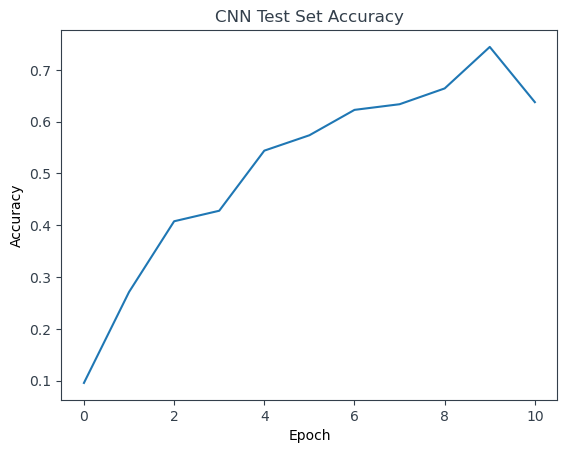

In [208]:
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("CNN Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

The target label is: 9


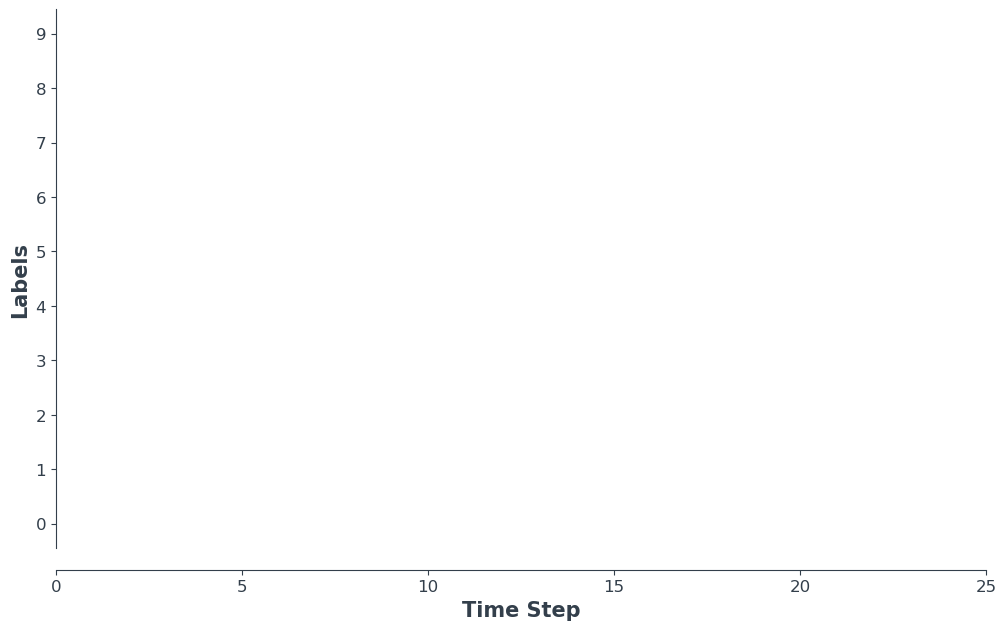

In [211]:
spk_rec, mem_rec = forward_pass(cnn, num_steps, data)
idx = 0
print(f"The target label is: {targets[idx]}")

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach(), fig, ax, labels=labels,
                        animate=True, interpolate=4)

HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")


# Advanced Techniques

## Regression 

https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_regression_1.html

Main idea is to use membrane potential as output, with a regression loss function.
```
self.fc_out = torch.nn.Linear(in_features=self.hidden, out_features=1)
self.li_out = snn.Leaky(beta=beta_out, threshold=1.0, learn_beta=True, spike_grad=spike_grad, reset_mechanism="none") # Note the reset mechanism is disabled and we will disregard output spikes.
loss_function = torch.nn.MSELoss()
```


## Binary SNN

https://github.com/jeshraghian/snntorch/blob/master/examples/tutorial_BSNN.ipynb

Binarization will convert all weights greater than 0 to 1, and all weights less than 0 to -1. This thresholding function is non-differentiable, so the training only takes the binarization in the forward-pass and ignores the binarization in the backward pass.

Executed in seperate notebook.

## Skip Connection

## Reccurent Neuron

https://snntorch.readthedocs.io/en/latest/snn.neurons_rleaky.html

LIF layers that take its output as input in the next timestep.

Comes with 1-d or 2-d learnable weights.

```
snn.RLeaky(beta, V=1.0, all_to_all=True, linear_features=None, conv2d_channels=None, ...)

```

In [ ]:
# 

## Spiking CNN Auto Encoder 

https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_sae.html